In [3]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

data = pd.read_csv('Data/tweets.csv', names=['Emotion', 'ID',
                                             'Date', 'Flag', 'User', 'Tweet_text'], encoding="ISO-8859-1")

In [13]:
df = pd.DataFrame(data['Emotion'].value_counts())
df.index = ['Negative','Positive']

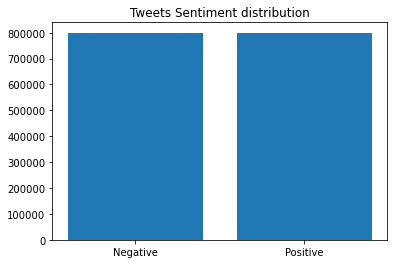

In [15]:
plt.bar(df.index, df['Emotion'])
plt.title("Tweets Sentiment distribution")
plt.show()

In [8]:
data.isnull().sum()

Emotion       0
ID            0
Date          0
Flag          0
User          0
Tweet_text    0
dtype: int64

In [11]:
def pre_process(text):
    # convert the text to lowercase
    text = text.lower()
    # remove tags
    text = re.sub("", "", text)
    # remove \n (newline tags)
    text = re.sub("\n", " ", text)

    # replace Urls to URLADDR
    text = re.sub("(?P<url>https?://[^\s]+)", "", text)
    # replace .co's/.com's to URLADDR
    text = re.sub("[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?",
                  "", text)
    # replace email addresses to EMAILADDR
    text = re.sub("\S*@\S*\s?", "", text)
    # replace currency values to CURRENCY
    text = re.sub("(?:[\£\$\€]{1}[,\d]+.?\d*)", "", text)
    # replace numbers to NUMBER
    text = re.sub("r[0-9]+", "", text)

    # remove html tags
    text = re.sub('<[^>]+>', '', text)

    # remove special characters and digits
    text = re.sub('[^A-Za-z ]+', ' ', text)

    return text

In [12]:
# Combining the subject and email into the text column for text pre processing
data['cleaned_text'] = data['Tweet_text'].apply(lambda x: pre_process(x))

In [13]:
stop_words = stopwords.words('english')
docs = data['cleaned_text'].tolist()


def tokenizer_new(text):
    lemmatizer = WordNetLemmatizer()
    tokens = [word for word in nltk.word_tokenize(text)]
    words = []
    for word in tokens:
        if word not in stop_words:
            words.append(word)

    lems = [lemmatizer.lemmatize(item, 'v') for item in words]
    return lems

In [19]:
"""
Creating Tf-Idf vectors
"""
vectorizer = TfidfVectorizer(tokenizer=tokenizer_new, lowercase=False)
X = vectorizer.fit_transform(docs)

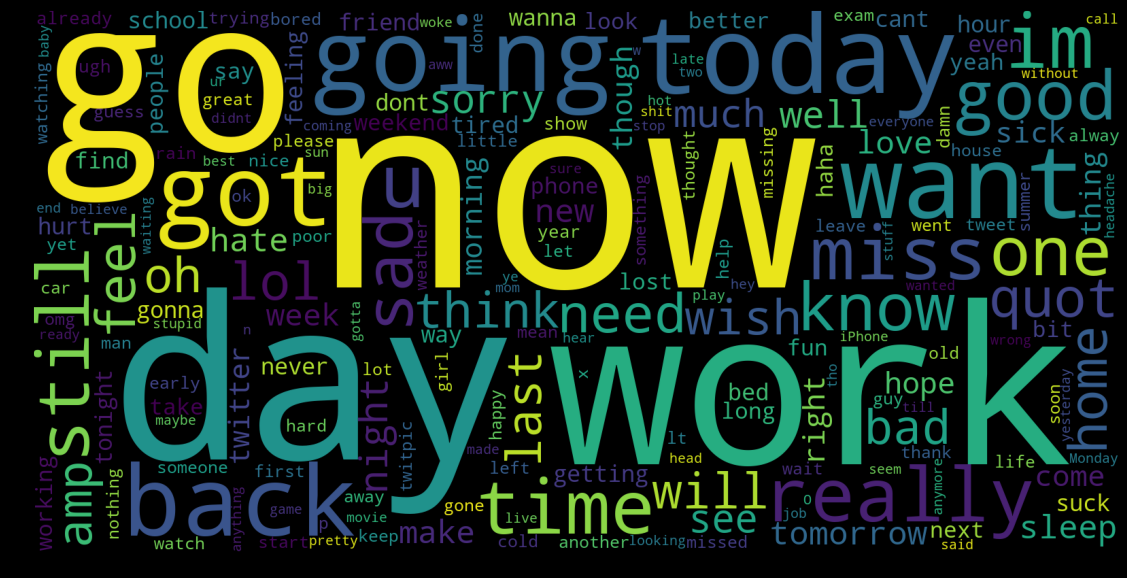

In [24]:
# Negative sentiment
wordcloud = WordCloud(background_color="black", width=1600, height=800,
                      random_state=0,
                      collocations=False, stopwords=STOPWORDS).generate(' '.join(data.loc[data['Emotion'] == 0, :]['Tweet_text'].tolist()))

plt.figure(figsize=(20, 10), facecolor='k')
plt.imshow(wordcloud)

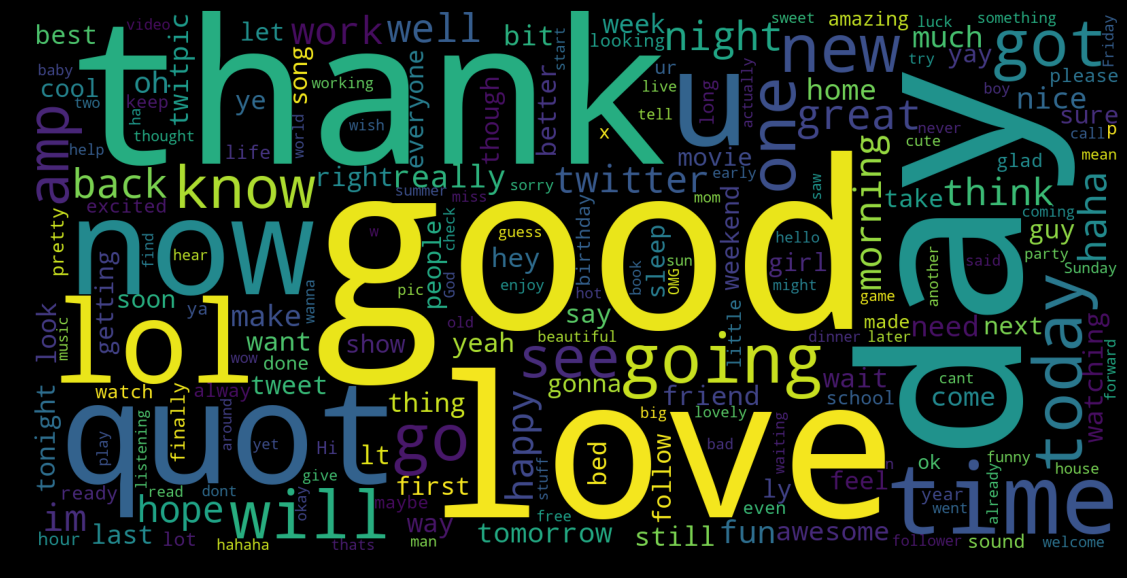

In [25]:
# Positive sentiment
wordcloud = WordCloud(background_color="black", width=1600, height=800,
                      random_state=0,
                      collocations=False, stopwords=STOPWORDS).generate(' '.join(data.loc[data['Emotion'] == 4, :]['Tweet_text'].tolist()))

plt.figure(figsize=(20, 10), facecolor='k')
plt.imshow(wordcloud)

In [16]:
cleaned_data = pd.read_csv('Data/tweets_cleaned.csv')

In [17]:
cleaned_data.head()

,tweet_id,created_at,text,cleaned_text,polarity_raw,vader_compound_raw,vader_pos_raw,vader_neu_raw,vader_neg_raw,polarity_cleaned,vader_compound_cleaned,vader_pos_cleaned,vader_neu_cleaned,vader_neg_cleaned,username,_50,_70,_100
0,1565014948,2009-04-20 05:39:01,@Wumbologist huh uhu...i see dead people xD ab...,huh uhu dead people xd abhalte kann ich dich ned,-0.2,-0.1280,0.210,0.552,0.238,-0.2,-0.1280,0.236,0.497,0.267,000catnap000,0,0,0
1,1957229112,2009-05-28 23:53:20,awake since six o'clock... i had two hours sle...,awake clock hours sleep visit sweetheart jasmi...,0.0,0.6486,0.223,0.777,0.000,0.0,0.6486,0.381,0.619,0.000,000catnap000,0,0,0
2,1981357110,2009-05-31 08:59:07,this is one of the cartoons i used to watch to...,cartoons watch brother good times,0.1,0.4404,0.146,0.854,0.000,0.7,0.4404,0.420,0.580,0.000,000catnap000,0,0,0
3,2058432528,2009-06-06 14:55:54,@Wumbologist hmmm...why not,hmmm,0.0,0.0000,0.000,1.000,0.000,0.0,0.0000,0.000,1.000,0.000,000catnap000,0,0,0
4,2058981540,2009-06-06 16:00:48,can't get enough of it http://bit.ly/134sSZ,NaN,0.0,0.0000,0.000,1.000,0.000,0.0,0.0000,0.000,0.000,0.000,000catnap000,0,0,0


In [47]:
cols = ['_50','_70','_100']
df = pd.DataFrame(columns = ['Threshold','Data points'])
for val in cols:
    df = df.append({'Threshold':val[1:],'Data points':cleaned_data[val].value_counts()[1]},
                  ignore_index= True)
df

,Threshold,Data points
0,50,74441
1,70,46111
2,100,23792


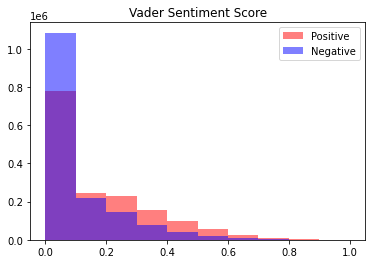

In [36]:
plt.title("Vader Sentiment Score")
plt.hist(cleaned_data.vader_pos_raw,color='red', alpha = 0.5, label = 'Positive')
plt.hist(cleaned_data.vader_neg_raw, color ='blue', alpha = 0.5,label= 'Negative')
plt.legend()
plt.show()